# **Infer `Cellmask` and `Nucleus`**

***Prior to this notebook, you should have already run through [1.0_image_setup](1.0_image_setup.ipynb).***

### ➡️ **Input:**
In this workflow, a single or multi-channel confocal microscopy image of fluorescently tagged organelles will be used to "infer" (or segment) the cell and nucleus masks. The following setup is recommended for this pipeline:

| **Imaging Requirements**|[**Masks Workflow (B)**](./1.1b_infer_masks_from-composite_multiple-cells.ipynb)| 
| :------------------------------------- |  :------:  |
| Nuclei Marker                          |     ✘     |
| Cell Membrane Marker                   |     ✘     |
| Cytoplasmic Organelles                 |     ✔     |
| Number of cells per image              |  Multiple |

*If your images are not compatible with this setup, consider the other 1.1_Masks Workflows available:*

| **Imaging Requirements**|[**Masks Workflow**](./1.1_infer_masks_from-composite_with_nuc.ipynb)|[**Masks Workflow (A)**](./1.1a_infer_masks_from-composite_single_cell.ipynb)|
| :------------------------------------- |  :------:  |  :------:  |
| Nuclei Marker                          |     ✔     |      ✘     |
| Cell Membrane Marker                   |     ✘     |      ✘     |
| Cytoplasmic Organelles                 |     ✔     |      ✔     |
| Number of cells per image              |  Single or Multiple  |   Single   |

*This workflow utilizes similar logic to `Masks A`, but can be applied to images with multiple cells per field of view.*

### **Included in this Notebook:**
1. **Infer *cytoplasm*** - Segment the ***cytoplasm*** from a composite image of multiple organelle markers combined. The ***cell*** and ***nucleus*** masks will be derived from this image.
    
    *The combination of organelle markers used to create the composite image for the cytoplasm segmentation is based on the assumption that the organelle labels used will "fill up" the entire cytoplasm (not including the nucleus). This is NOT the most accurate method to determine the cell area, but is required in the case where membrane and nuclei markers can not be used or are not included. It is important to consider the specifics of your system as the cell type and labeling method may differ from the example used to optimize this workflow.*

2. **Infer *nucleus*** - Segment the ***nucleus*** from an exclusive or (XOR) of the ***cytoplasm*** mask and a hole-filled version of the ***cytoplasm*** mask.
3. **Infer *cellmask***
Segment the ***cellmask*** by combining the ***nucleus*** and ***cytoplasm*** masks. To create an instance segmentation of the cellmask, the nuclei will be used as the seeds for the watershed operation. Then, the cell with the highest combined fluorescence intensity will be considered the main cell for analysis and everything else will be discarded. The nuclei and cytoplasm associated to that cell will be selected by masking.
-----

### 👣 **Summary of steps**  

➡️ **EXTRACTION**
- **`STEP 1`** - Create composite image

    - determine weight to apply to each channel of the intensity image (w# = user input)
    - rescale summed image intensities (rescale = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

    - rescale intensity of composite image (min=0, max=1)
    - median filter (median size = user input)
    - gaussian filter (sigma = user input)

- **`STEP 3`** - Log transform + Scharr edge detection

    - perform a log transformation on the image
    - apply Scharr edge detection filter
    - combine log image and Scharr edge filtered intensity image
 
**CORE PROCESSING**
- **`STEP 4`** - Semantic segmentation of the cytoplasm

    - (A) apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)
    - (B) fill holes and remove small objects (hole size = user input, object size = user input, method = user input)
    
- **`STEP 5`** - Segmentation of nuclei ‘seeds’ from cytoplasm

    - (A) binary opening of inverted aggregate cytoplasm mask; remove the nuclei in aggregate cytoplasm mask (hole size = user input) and select the removed items with a logical **XOR** with the inverted cytoplasm
    - (B) remove small objects (object size = user input)
    
- **`STEP 6`** - Combine nucleus masks and cytoplasm masks

    - logical **OR** of the nucleus and cytoplasm
    - fill gaps (hole size = user input)

**POST-PROCESSING**
- **`STEP 7`** - Label cells based on nuclei 'seeds'; isolate highest intensity

    - perform a masked inverted watershed with the aggregate cellmask segmentation and the nuclei seeds
    - select the label with the highest total intensity

**POST-POST-PROCESSING**
- **`STEP 8`** - Segmentation of single nucleus from cytoplasm; cell mask applied

    - logical **AND** of the cellmask and aggregate cytoplasm mask
    - invert cytoplasm mask and clear border (nucleus mask)
    - fill holes (hole size = user input)
    - remove small objects (object size = user input)

**EXPORT** ➡️
- **`STEP 9`** - Stack masks

    - stack masks in order of nucleus, cellmask and cytoplasm mask

---------------------
## **IMPORTS AND LOAD IMAGE**
Details about the functions included in this subsection are outlined in the [`1.0_image_setup`](1.0_image_setup.ipynb) notebook. Please visit that notebook first if you are confused about any of the code included here.

#### &#x1F3C3; **Run code; no user input required**

In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import napari
from napari.utils.notebook_display import nbscreenshot

from skimage.segmentation import clear_border
from skimage.morphology import binary_opening
from skimage.measure import label

from infer_subc.core.file_io import (read_czi_image,
                                     export_inferred_organelle,
                                     list_image_files)        
from infer_subc.core.img import *
from infer_subc.organelles import non_linear_cellmask_transform

%load_ext autoreload
%autoreload 2


#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following information about your data: `im_type`, `data_root_path`, `in_data_path`, and `out_data_path`.

In [2]:
#### USER INPUT REQUIRED ###
im_type = ".czi"
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"
in_data_path = data_root_path / "raw"
out_data_path = data_root_path / "out"

#### &#x1F3C3; **Run code; no user input required**

In [3]:
# list files in the input folder
img_file_list = list_image_files(in_data_path,im_type)
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"Image Name":img_file_list})

,Image Name
0,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\11252023_MSi08L_iPSCs_undiff_BR1_N20_Unmixing.czi
1,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\24hrs-Ctrl +oleicAcid 50uM_2_Unmixing.czi
2,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\24hrs-Ctrl +oleicAcid 50uM_3_Unmixing.czi
3,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl +oleicAcid 50uM_10_Unmixing.czi
4,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl +oleicAcid 50uM_4_Unmixing.czi
5,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_10_Unmixing.czi
6,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_14_Unmixing.czi
7,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_01_Unmixing.czi
8,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_02_Unmixing.czi
9,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_07_Unmixing.czi


#### &#x1F6D1; &#x270D; **User Input Required:**

Use the list above to specify which image you wish to analyze based on its index: `test_img_n`

In [4]:
#### USER INPUT REQUIRED ###
test_img_n = 5

#### &#x1F3C3; **Run code; no user input required**

In [5]:
# load image and metadata
test_img_name = img_file_list[test_img_n]
img_data,meta_dict = read_czi_image(test_img_name)

# metadata
channel_names = meta_dict['name']
meta = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
file_path = meta_dict['file_name']
print("Metadata information")
print(f"File path: {file_path}")
for i in list(range(len(channel_names))):
    print(f"Channel {i} name: {channel_names[i]}")
print(f"Scale (ZYX): {scale}")
print(f"Channel axis: {channel_axis}")

# open viewer and add images
viewer = napari.Viewer()
for i in list(range(len(channel_names))):
    viewer.add_image(img_data[i],
                     scale=scale,
                     name=f"Channel {i}")
viewer.grid.enabled = True
viewer.reset_view()
print("\nProceed to Napari window to view your selected image.")

Metadata information
File path: C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_10_Unmixing.czi
Channel 0 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Nuclei_Jan22
Channel 1 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Lyso+405_Jan22
Channel 2 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Mito+405_Jan22
Channel 3 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Golgi+405_Jan22
Channel 4 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Peroxy+405_Jan22
Channel 5 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: ER+405_Jan22
Channel 6 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: BODIPY+405low_Jan22
Channel 7 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Residuals
Scale (ZYX): (0.3891184878080979, 0.07987165184837317, 0.07987165184837318)
Channel axis: 0


21-Nov-24 11:17:10 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1086x656+388-308 (frame: 1104x703+379-346) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1360x822+389-301 (frame: 1378x869+380-339) margins: 9, 38, 9, 9 minimum size: 385x515 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=403,562 maxtrack=0,0)



Proceed to Napari window to view your selected image.


-----

## **EXTRACTION**

### **`STEP 1` - Create composite image**

&#x1F453; **FYI:** This code block creates a composite image of the organelle channels. The intensity of each channel in combined together with specified weights. The resulting composite will be used to segment the cytoplasm area. 

*Hint: combine organelles in a way that produces a relatively even intensity throughout the cell.* 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `w0`: the weight of channel 0 (the first channel); a value of 0 will exclude this channel from the compostite; large values will cause this channel to be more prominent in the final composite image
- `w1`: the weight of channel 1
- `w2`: the weight of channel 2
- `w3`: the weight of channel 3
- `w4`: the weight of channel 4
- `w5`: the weight of channel 5
- `w6`: the weight of channel 6
- `w7`: the weight of channel 7
- `w8`: the weight of channel 8
- `w9`: the weight of channel 9
- `rescale`: "True" rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0; "False" leaves the combined intensity values as is after the composite is made

## **`STEP 1` - Create composite image**

- determine weight to apply to each channel of the intensity image (w# = user input)
- rescale summed image intensities (rescale = user input)

In [6]:
#### USER INPUT REQUIRED ###
w0 = 4
w1 = 3
w2 = 1
w3 = 1
w4 = 6
w5 = 6
w6 = 0
w7 = 0
w8 = 0
w9 = 0

cyto_rescale = True

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block creates the composite and optionally rescales the image based on the settings above. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the smoothing settings selected above.

In [7]:
# make aggregate and optionally rescale
struct_img_raw = make_aggregate(img_data,
                                weight_ch0= w0,
                                weight_ch1= w1,
                                weight_ch2= w2,
                                weight_ch3= w3,
                                weight_ch4= w4,
                                weight_ch5= w5,
                                weight_ch6= w6,
                                weight_ch7= w7,
                                weight_ch8= w8,
                                weight_ch9= w9,
                                rescale = cyto_rescale)

# adding image to Napari as a new layer
viewer.layers.clear()
viewer.grid.enabled = False
viewer.reset_view()
viewer.add_image(img_data, scale=scale)
viewer.add_image(struct_img_raw, scale=scale, name="1-Cyto: Create composite")

<Image layer '1-Cyto: Create composite' at 0x14f0d1a8790>

-----
## **PRE-PROCESSING**

## **`STEP 2` - Rescale and smooth image**

&#x1F453; **FYI:** This code block rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0. The image is then *optionally* smoothed using a Gaussian and/or median filter. 

<mark> Include more information on the Gaussian and median filtering methods here </mark>

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the amount of filter to use for each method. Higher values indicate more smoothing:
- `med_filter_size`: the size of the median filter to apply; if 0 is used, no filter will be applied
- `gaussian_smoothing_sigma`: the sigma to apply in the Gaussian filtering step; if 0 is used, no filter will be applied

In [8]:
#### USER INPUT REQUIRED ###
cyto_med_filter_size = 5
cyto_gaussian_smoothing_sigma = 1.34

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block rescales the image and applies the specified median and Gaussian filters. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the smoothing settings selected above.

In [9]:
# rescaling and smoothing input image
structure_img_smooth = scale_and_smooth(struct_img_raw,
                                        median_size = cyto_med_filter_size, 
                                        gauss_sigma = cyto_gaussian_smoothing_sigma)


# adding image to Napari as a new layer
viewer.add_image(structure_img_smooth, scale=scale, name="2-Cyto: Rescale and Smooth")

<Image layer '2-Cyto: Rescale and Smooth' at 0x14f0f70ee90>

### **`STEP 3` - Log transform + Scharr edge detection**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies a log transform and the [Scharr](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.scharr) edge detection filter.

Use the Napari viewer to iteratively adjust the filter settings as needed.

*Hint: if may be helpful to readjust the composite and smoothing settings to improve the outcome of this step.*

In [10]:
# log scale the image, apply the scharr edge detection filter to logged image, add the two images together
composite_cytomask = non_linear_cellmask_transform(structure_img_smooth)

# adding image to Napari as a new layer
viewer.add_image(composite_cytomask, scale=scale, name="3-Cyto: Log Scharr edge detectiong")

<Image layer '3-Cyto: Log Scharr edge detectiong' at 0x14f0b10eb00>

-----
## **CORE-PROCESSING**

### **`STEP 4` - Semantic segmentation of the cytoplasm**
#### `A. Global + local thresholding (AICSSeg – MO)`

&#x1F453; **FYI:** This code block creates a semantic segmentation of the cytoplasmic area. `Semantic segmentation` is the process of deciding whether a pixel/voxel should be included in an object (labeled with a value of 1) or should be considered as part of the background (labeled with a value of 0). A semantic segmentation does not discern individual objects from one another.

The masked_object_filter utilizes the 'MO' filter from the [`aics-segmentation`](https://github.com/AllenCell/aics-segmentation) package. AICS documentation states: "The algorithm is a hybrid thresholding method combining two levels of thresholds. The steps are [1] a global threshold is calculated, [2] extract each individual connected componet after applying the global threshold, [3] remove small objects, [4] within each remaining object, a local Otsu threshold is calculated and applied with an optional local threshold adjustment ratio (to make the segmentation more and less conservative). An extra check can be used in step [4], which requires the local Otsu threshold larger than 1/3 of global Otsu threhsold and otherwise this connected component is discarded."

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `thresh_method`: the global thresholding method; options include 'tri'/'triangle, 'med'/'median' or 'ave'/'ave_tri_med'. Triangle implements the [skimage.filters.threshold_triangle](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_triangle) method, median utilizes the 50th percentile of the intensities, and ave uses the average of the two methods to calculate the lower bound of the global threshold.
- `cell_wise_min_area`: the minimum expected size of your object; smaller objects will be removed prior to local thresholding
- `thresh_adj`: adjustment to make to the local threshold; larger values make the segmentation more stringent (less area included)

In [11]:
#### USER INPUT REQUIRED ###
cyto_thresh_method = 'med'
cyto_cutoff_size =  500
cyto_thresh_adj = 0.9

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the MO filter using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed.

In [12]:
# threshold the composite image after log/edge detection using the MO filter function from aicssegmentation - this applies a global threshold, then a local threshold to produce a semantic segmentation
bw = masked_object_thresh(composite_cytomask, 
                          global_method=cyto_thresh_method, 
                          cutoff_size=cyto_cutoff_size, 
                          local_adjust=cyto_thresh_adj)

# adding image to Napari as a new layer
viewer.add_image(bw, scale=scale, name="4-Cyto: MO filter", opacity=0.3, colormap="cyan", blending='additive')

<Image layer '4-Cyto: MO filter' at 0x14f0d48e170>

#### `B - Remove small holes and objects`

&#x1F453; **FYI:** This code block cleans up the semantic segmentation by filling small holes and/or removing small objects that can be considered errors in the initial segmentation. 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_min_width`: the width of the smallest hole to be filled
- `hole_max_width`: the width of the largest hole to be filled
- `small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed
- `fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results is higher or lower Z planes.

In [13]:
#### USER INPUT REQUIRED ###
cyto_hole_min_width = 0
cyto_hole_max_width = 20

cyto_small_object_width = 30

cyto_fill_filter_method = "slice_by_slice"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block fills small holes and removes small objects using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

In [14]:
# fill small holes and remove small objects
cleaned_img2 = fill_and_filter_linear_size(bw, 
                                           hole_min=cyto_hole_min_width, 
                                           hole_max=cyto_hole_max_width, 
                                           min_size=cyto_small_object_width,
                                           method=cyto_fill_filter_method)

# force all sections of the cytoplasm to be labeled as 1 even if they are separated
cytoplasm_mask = label_bool_as_uint16(cleaned_img2)

# adding image to Napari as a new layer
viewer.add_image(cytoplasm_mask, scale=scale, name="4-Cyto: Fill holes and remove small objects", colormap="magenta")

<Image layer '4-Cyto: Fill holes and remove small objects' at 0x14f0d2d8160>

### **`STEP 5` - Segmentation of nuclei ‘seeds’ from cytoplasm**

&#x1F453; **FYI:** This code block uses the cytoplasm mask to create qpproximation of the nuclei. The nuclei "seeds" will be used to distinguish between individual cells in the image. The process includes a [binary opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.binary_opening) of the inverted cytoplasm masks; the binary opening step increases the likelihood that the nuclei and extracellular space are separated (i.e., without gaps connecting them). The nuclei objects are then selected by removing them and comparing what was removed to the previous output using a logical exclusive or function. The final nuclei output is then cleaned up with a fill and filter step.

#### `A. Select nuclei from cytoplasm`

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `max_nuc_width`: the maximum expected width of the nuclei

***Hint: if the background area is still included then your "max_nuc_width" value is too large.***

*Note: the fill_and_filter_linear_size function is utilized here, but only the small object feature is initiated.*

In [15]:
#### USER INPUT REQUIRED ###
max_nuc_width = 150

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block selects the nuclei using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

In [16]:
# invert cytoplasm mask
cytoplasm_inverse = 1 - cytoplasm_mask

# binary opening of inverted aggregate cytoplasm mask (erosion -> dilation)
cytoplasm_inv_opened = binary_opening(cytoplasm_inverse, footprint=np.ones([3,3,3]))

# fill nuclei in aggregate cytoplasm mask (hole size = user input)
nuc_removed = fill_and_filter_linear_size(cytoplasm_inv_opened, 
                                          hole_max=0, 
                                          hole_min=0, 
                                          min_size=max_nuc_width, 
                                          method='3D')

# logical **XOR** of the cytoplasm and the filled in cytoplasm resulting in the nucleus and any artifacts from binary opening
nuc_objs = np.logical_xor(cytoplasm_inv_opened, nuc_removed)

# adding image to Napari as a new layer
viewer.add_image(nuc_objs, scale=scale, name="5-Nuc: select nuclei", blending="additive", opacity=0.3)

<Image layer '5-Nuc: select nuclei' at 0x14f0bf7f9a0>

### `B. Filter out small objects from nuclei mask`

&#x1F453; **FYI:** This code removes small objects from the nuclei mask generated above.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `nuc_min_obj_width`: the width of the largest object to be removed; any object smaller than this size will be removed

*Note: the fill_and_filter_linear_size function is utilized here, but only the small object feature is initiated.*

In [17]:
#### USER INPUT REQUIRED ###
nuc_min_obj_width = 20

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block removes small objects using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

In [18]:
# remove small objects
nuc_cleaned = fill_and_filter_linear_size(nuc_objs, 
                                          hole_max=0, 
                                          hole_min=0, 
                                          min_size=nuc_min_obj_width, 
                                          method='3D')
nuc_labels = label_uint16(nuc_cleaned)

# adding image to Napari as a new layer
viewer.add_image(nuc_labels, scale=scale, name="5-Nuc: Nuclei cleaned", colormap='blue')

<Image layer '5-Nuc: Nuclei cleaned' at 0x14f0b1388b0>

### **`STEP 6` - Combine nucleus masks and cytoplasm masks**

&#x1F453; **FYI:** This code block adds the final nucleus and cytoplasm objects together to create the final cell mask. Then, the fill and filter function is applied to clean up any errors.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_max_width`: the width of the largest hole to be filled between the nuclei seeds and the cytoplasm mask

In [19]:
#### USER INPUT REQUIRED ###
cell_hole_max_width = 20

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block creates the cell mask and cleans it up using the settings specified above.

In [20]:
# logical **OR** of the nucleus and cytoplasm
cells = np.logical_or(nuc_labels, cytoplasm_mask)

# fill gaps (hole size = user input)
cell_multiple = fill_and_filter_linear_size(cells, 
                                            hole_min=0,
                                            hole_max=cell_hole_max_width,
                                            min_size=0,
                                            method='3D')

# adding image to Napari as a new layer
viewer.add_image(cell_multiple, scale=scale, name="6-Cell: Create cell mask")

<Image layer '6-Cell: Create cell mask' at 0x14f0baad840>

-----
## **POST-POST-PROCESSING**

### **`STEP 7` - Label cells based on nuclei 'seeds'; isolate highest intensity**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block takes the semantic segmentation of the cell and creates an `instance segmentation`. The process is accomplished with the [watershed](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) function where the nuclei are used as seeds to determine the approximate center of each cell. The cell and associated nucleus with the highest combined organelle intensity is then selected for downstream single-cell analysis. 

Then, the cell with the highest combined intensity is selected.

***Note: if there are more than on cell still appearing in the image, you may not have been able to segment a nuclei object associated to that cell. Consider repeating the nuclei segmentation steps above to improve your outcome here.***

*In the Napari viewer, the image is added as a "labels" layer where each object appears as a different color. There should only be a single nucleus and cytoplasm remaining at this stage.*

In [45]:
# perform a masked inverted watershed with the aggregate cellmask segmentation and the nuclei seeds
cell_labels = masked_inverted_watershed(cell_multiple, markers=nuc_labels, mask=cell_multiple, method='3D')

# create a composite from each intensity channel after they have been min-max normalized
norm_channels = [(min_max_intensity_normalization(img_data[c])) for c in range(len(img_data))]
normed_signal = np.stack(norm_channels, axis=0)

normed_composite = normed_signal.sum(axis=0)

# find the cell mask that has the highest intensity
all_labels = np.unique(cell_labels)[1:]
total_signal = [normed_composite[cell_labels == label].sum() for label in all_labels]

keep_label = all_labels[np.argmax(total_signal)]
good_cell = cell_labels == keep_label

# adding image to Napari as a new layer
viewer.layers.clear()
viewer.add_image(struct_img_raw, scale=scale)
viewer.add_labels(good_cell, scale=scale, name="7-Cell: Select one cell")

<Labels layer '7-Cell: Select one cell' at 0x14f8610bcd0>

-----
## **POST-POST-PROCESSING**

### **`STEP 8` - Segmentation of single nucleus from cytoplasm; cell mask applied**

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `cyto_small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed

*Note: the fill_and_filter_linear_size function is utilized here, but only the small object feature is initiated.*

In [46]:
#### USER INPUT REQUIRED ###
cyto_small_object_width2 = 10

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block masks a single nuclei and single cytoplasm based on the individual cell selected above. 

*In the Napari viewer, the image is added as a "labels" layer where each object appears as a different color. There should only be a single nucleus and cytoplasm remaining at this stage.*

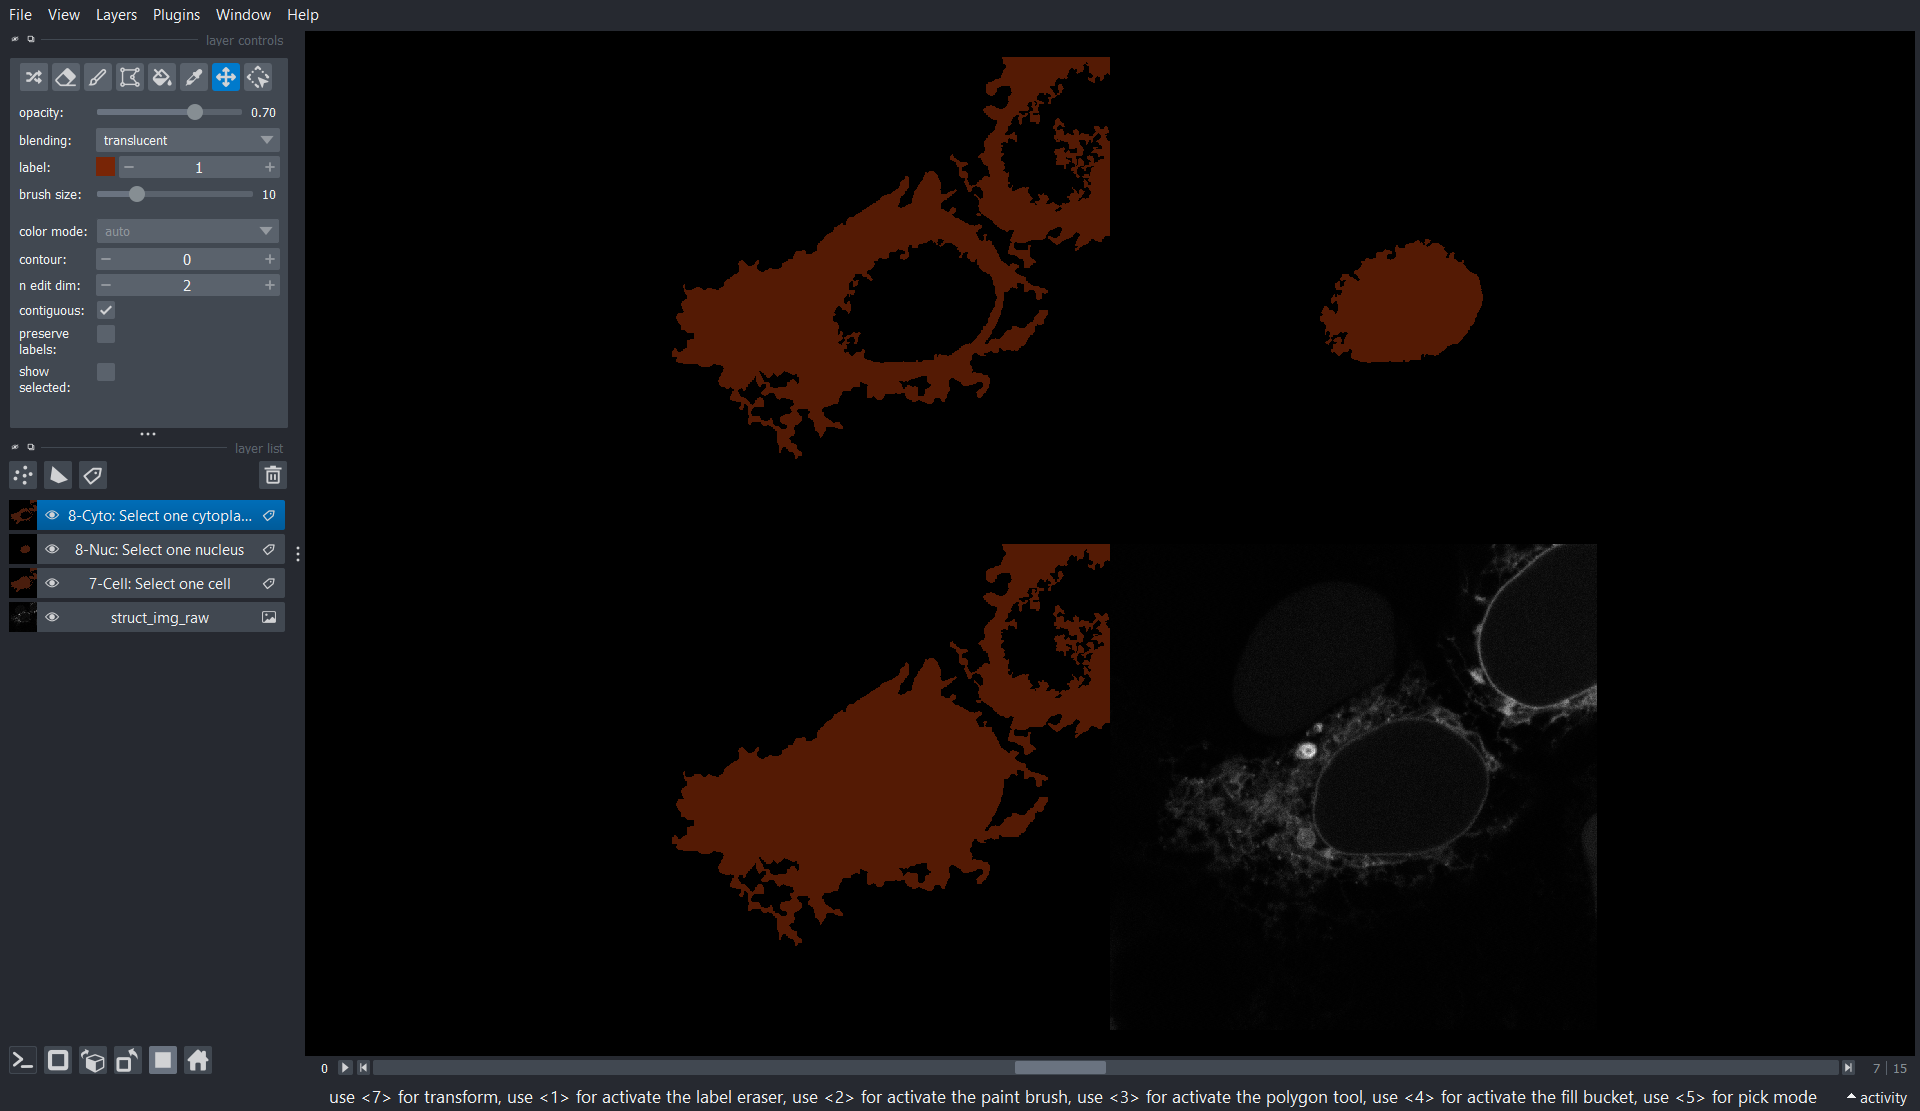

In [47]:
# logical **AND** of the cellmask and aggregate cytoplasm mask
good_cyto = apply_mask(cytoplasm_mask, good_cell).astype(bool)

# invert cytoplasm mask and clear border (nucleus mask)
good_cyto_inverse = 1 - good_cyto
nuc_single = clear_border(good_cyto_inverse)

# remove small objects
good_nuc = fill_and_filter_linear_size(nuc_single,
                                       hole_min=0,
                                       hole_max=0,
                                       min_size=cyto_small_object_width2,
                                       method='3D').astype(bool)

# adding image to Napari as a new layer
viewer.grid.enabled = True
viewer.add_labels(good_nuc, scale=scale, name="8-Nuc: Select one nucleus")
viewer.add_labels(good_cyto, scale=scale, name="8-Cyto: Select one cytoplasm")
viewer.reset_view()

# screenshot viewer
nbscreenshot(viewer, canvas_only = False)

## **`STEP 9` - Stack masks**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block stacks the single nucleus, cell, and cytoplasm masks into one multichannel image.

In [64]:
stack = stack_masks(nuc_mask=good_nuc, cellmask=good_cell, cyto_mask=good_cyto)
print(f"Stack mask file structure: {np.shape(stack)}")
print(f"The dimension of '3' represents the 'nucleus', 'cell', and 'cytoplasm' channel, in that order.")

Stack mask file structure: (3, 16, 704, 704)
The dimension of '3' represents the 'nucleus', 'cell', and 'cytoplasm' channel, in that order.


-----
## **SAVING**

## **`Saving` - Save the segmentation output**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block saves the instance segmentation output to the `out_data_path` specified earlier.

In [25]:
out_file_n = export_inferred_organelle(stack, "masks_B", meta_dict, out_data_path)

saved file: a24hrs-Ctrl_10_Unmixing-masks_B


-----
-----
## **Define functions**
The following code includes an example of how the workflow steps above are combined into functions. The final combined `infer_masks_B` function can be run below to process a single image. It is included in the <mark>batch process notebook</mark> to run the above analysis on multiple cells. 

This function can utilized from infer-subc using:
```python
infer_subc.organelles.masks.infer_masks_B()
```

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `segment_cytoplasm_area()`, function. It is applied below.

In [26]:
##########################
# infer_cytoplasm_fromcomposite
# alternative workflow "b"
##########################
def _infer_cytoplasm_fromcomposite(in_img: np.ndarray,
                                  weights: list[int],
                                  rescale: bool,
                                  median_sz: int,
                                  gauss_sig: float,
                                  mo_method: str,
                                  mo_adjust: float,
                                  mo_cutoff_size: int,
                                  min_hole_w: int,
                                  max_hole_w: int,
                                  small_obj_w: int,
                                  fill_filter_method: str
                                  ) -> np.ndarray:
    """
    Procedure to infer cellmask from linear unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    weights:
        a list of int that corresond to the weights for each channel in the composite; use 0 if a channel should not be included in the composite image
    rescale:
        True = rescale composite
        False = don't rescale composite
    nuclei_labels: 
        a 3d image containing the inferred nuclei labels
    median_sz: 
        width of median filter for _cellmask_ signal
    gauss_sig: 
        sigma for gaussian smoothing of _cellmask_ signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w: 
        minimu object size cutoff for cellmask signal post-processing
    fill_filter_method:
        determines if fill and filter should be run 'sice-by-slice' or in '3D' 

    Returns
    -------------
    cellmask_mask:
        a logical/labels object defining boundaries of cellmask

    """
    ###################
    # EXTRACT
    ###################
    struct_img = make_aggregate(in_img, *weights, rescale)

    ###################
    # PRE_PROCESSING
    ###################                         
    struct_img = scale_and_smooth(struct_img,
                                   median_size = median_sz, 
                                   gauss_sigma = gauss_sig)
    

    struct_img_non_lin = non_linear_cellmask_transform(struct_img)

    ###################
    # CORE_PROCESSING
    ###################
    struct_obj = masked_object_thresh(struct_img_non_lin, 
                                      global_method=mo_method, 
                                      cutoff_size=mo_cutoff_size, 
                                      local_adjust=mo_adjust)               

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(struct_obj, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size= small_obj_w,
                                             method=fill_filter_method)

    ###################
    # POST- POST_PROCESSING
    ###################
    cellmask_out = label_bool_as_uint16(struct_obj)

    return cellmask_out

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [30]:
_CY_object = _infer_cytoplasm_fromcomposite(img_data,
                                                 [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9],
                                                 cyto_rescale,
                                                 cyto_med_filter_size,
                                                 cyto_gaussian_smoothing_sigma,
                                                 cyto_thresh_method,
                                                 cyto_thresh_adj,
                                                 cyto_cutoff_size,
                                                 cyto_hole_min_width,
                                                 cyto_hole_max_width,
                                                 cyto_small_object_width,
                                                 cyto_fill_filter_method)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(cytoplasm_mask == _CY_object)}")

The segmentation output here matches the output created above: True


In [31]:
from infer_subc.organelles.cytoplasm import infer_cytoplasm_fromcomposite
CY = infer_cytoplasm_fromcomposite(img_data,
                                    [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9],
                                    cyto_rescale,
                                    cyto_med_filter_size,
                                    cyto_gaussian_smoothing_sigma,
                                    cyto_thresh_method,
                                    cyto_thresh_adj,
                                    cyto_cutoff_size,
                                    cyto_hole_min_width,
                                    cyto_hole_max_width,
                                    cyto_small_object_width,
                                    cyto_fill_filter_method) 

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(CY == _CY_object)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `segment_nuclei_seeds()`, function. It is applied below.

In [ ]:
def _segment_nuclei_seeds(cyto_seg: np.ndarray,
                          max_nuclei_width: int,
                          small_obj_width: int):
    """ 
    Procedure to segment approximations of the nuclei from a binary mask of the cytoplasm (image with more than one cell)
    
    Parameters
    ----------
    cyto_seg: np.ndarray
        a binary mask of the cytoplasm
    max_nuclei_width: int
        the maximum expected width of the nuclei
    small_obj_width: int
        width of the any small objects that may be left over after nuclei are selected (i.e., errors in the seg)

    Returns
    ----------
    nuclei mask:
        a labeled image of one or more nuclei
    """
    # create the inverse of the cytoplasm and increase likelihood for object separation with binary opening
    cytoplasm_inverse = 1 - cyto_seg
    cytoplasm_inv_opened = binary_opening(cytoplasm_inverse, footprint=np.ones([3,3,3]))

    # isolate the nuclei objects that fill be used as seeds for watershed
    # these aren't exactly the inverse of the cytoplasm because of the binary opening
    nuc_removed = fill_and_filter_linear_size(cytoplasm_inv_opened, 
                                            hole_max=0, 
                                            hole_min=0, 
                                            min_size=max_nuclei_width, 
                                            method='3D')

    nuc_objs = np.logical_xor(cytoplasm_inv_opened, nuc_removed)

    # remove an small debris leftover that aren't the correct size for nuclei
    nuc_cleaned = fill_and_filter_linear_size(nuc_objs, 
                                            hole_max=0, 
                                            hole_min=0, 
                                            min_size=small_obj_width, 
                                            method='3D')
    

    return label_uint16(nuc_cleaned)

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [69]:
_NU_object = _segment_nuclei_seeds(cytoplasm_mask, 
                                   max_nuclei_width=max_nuc_width,
                                   small_obj_width=nuc_min_obj_width)


# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(nuc_labels == _NU_object)}")

The segmentation output here matches the output created above: True


In [35]:
from infer_subc.organelles.nuclei import segment_nuclei_seeds
NU = segment_nuclei_seeds(cytoplasm_mask, 
                          max_nuclei_width=max_nuc_width, 
                          small_obj_width=nuc_min_obj_width)


# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(NU == _NU_object)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `combine_cytoplasm_and_nuclei()`, function. It is applied below.

In [36]:
def _combine_cytoplasm_and_nuclei(cyto_seg: np.ndarray,
                                  nuc_seg: np.ndarray,
                                  fillhole_max: int):
    """
    Function to combine the the cytoplasm and nuclei segmentations to produce the entire cell mask.

    Parameters:
    ----------
    cyto_seg: np.ndarray,
        image containing the cytoplasm segmentation
    nuc_seg: np.ndarray,
        image containing the nuclei segmentation
    fillhole_max: int
        size of the gaps between the nuclei and cytoplasm (usually small)
    """ 
    
    cells = np.logical_or(cyto_seg.astype(bool), nuc_seg.astype(bool))

    cell_multiple = fill_and_filter_linear_size(cells, 
                                                hole_min=0,
                                                hole_max=fillhole_max,
                                                min_size=0,
                                                method='3D')
    
    cell_area = cell_multiple.astype(bool)

    return cell_area

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [37]:
_CM_object = _combine_cytoplasm_and_nuclei(cytoplasm_mask, 
                                               nuc_labels, 
                                               cell_hole_max_width)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(cell_multiple == _CM_object)}")

The segmentation output here matches the output created above: True


In [38]:
from infer_subc.organelles.cellmask import combine_cytoplasm_and_nuclei
CM = combine_cytoplasm_and_nuclei(cytoplasm_mask, 
                                               nuc_labels, 
                                               cell_hole_max_width)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(CM == _CM_object)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `select_highest_intensity_cell()`, function. It is applied below.

In [ ]:
def _select_highest_intensity_cell(raw_image: np.ndarray,
                                   cell_seg: np.ndarray,
                                   nuc_seg: np.ndarray):
    """ 
    Create an instance segmentation of the cell area using a watershed operation based on nuclei seeds.
    Then, select the cell with the highest combined organelle intensity.

    Parameters:
    ----------
    raw_image: np.ndarray,
        gray scale 3D multi-channel numpy array (CZYX)
    cell_seg: np.ndarray,
        binary cell segmentation with multiple cells in the FOV
    nuc_seg: np.ndarray,
        labeled nuclei segmentation with each nuclei having a different ID number (e.g., the result of the skimage label() function)
    # labels_to_consider: Union(list, None)
    #     a list of labels that should be considered when determining the highest intensity. Default is None which utilizes all possible labels in the cell image
        
    Output
    ----------
    good_cell: np.ndarray  
        a binary image of the single cell with the highest total fluorescence intensity
    """
    # instance segmentation of cell area with watershed function
    cell_labels = masked_inverted_watershed(cell_seg, markers=nuc_seg, mask=cell_seg, method='3D')

    # TODO: add this for if multiple cells of interest
    # target_labels = None
    # labels_in = cell_labels

    # if target_labels is None:
    #     all_labels = np.unique(cell_labels)[1:]
    # else:
    #     all_labels = np.unique(target_labels)[1:]

    # create composite of all fluorescence channels after min-max normalization
    norm_channels = [(min_max_intensity_normalization(raw_image[c])) for c in range(len(raw_image))]
    normed_signal = np.stack(norm_channels, axis=0)
    normed_composite = normed_signal.sum(axis=0)

    # list of cell IDs to measure intensity of
    all_labels = np.unique(cell_labels)[1:]

    # measure total intensity in each cell from the ID list
    total_signal = [normed_composite[cell_labels == label].sum() for label in all_labels]

    # select the cell with the highest total intensity
    keep_label = all_labels[np.argmax(total_signal)]
    good_cell = cell_labels == keep_label

    return good_cell

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [49]:
_good_CM = _select_highest_intensity_cell(img_data, 
                                          cell_multiple, 
                                          nuc_labels)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(good_cell == _good_CM)}")

The segmentation output here matches the output created above: True


In [51]:
from infer_subc.organelles.cellmask import select_highest_intensity_cell
good_CM = select_highest_intensity_cell(img_data, 
                                         cell_multiple, 
                                         nuc_labels)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(good_CM == _good_CM)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `mask_cytoplasm_nuclei()`, function. It is applied below.

In [65]:
def _mask_cytoplasm_nuclei(cellmask: np.ndarray,
                           cyto_seg: np.ndarray,
                           small_obj_size: int):
    """ 
    mask the cytoplasm with the cell mask to isolate the cytoplasmic area of intereste.
    create a single nuclei segmentation from the inverse of the cytoplas (no binary opening)

    Parameters:
    ----------
    cellmask: 
        binary segmentation of a single cell
    cyto_seg:
        semantic segmentation of cytoplasm from multiple cells in an image
    small_obj_size:
        size of small objects to be removed from the final nucleus segmentation image
    """

    good_cyto = apply_mask(cyto_seg, cellmask).astype(bool)

    good_cyto_inverse = 1 - good_cyto

    nuc_single = clear_border(good_cyto_inverse)

    good_nuc = fill_and_filter_linear_size(nuc_single,
                                        hole_min=0,
                                        hole_max=0, 
                                        min_size=small_obj_size,
                                        method='3D')
    
    # return good_nuc, good_cyto

    stack = stack_masks(nuc_mask=good_nuc, cellmask=cellmask, cyto_mask=good_cyto)
    
    return stack

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [66]:
_good_MS = _mask_cytoplasm_nuclei(good_cell, 
                                  cytoplasm_mask, 
                                  cyto_small_object_width2)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(stack == _good_MS)}")

The segmentation output here matches the output created above: True


In [67]:
from infer_subc.organelles.nuclei import mask_cytoplasm_nuclei
good_MS = mask_cytoplasm_nuclei(good_cell, 
                                cytoplasm_mask, 
                                cyto_small_object_width2)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(good_MS == _good_MS)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_masks_A()`, function, the complete function that combined the thress above functions and will be used for batch processing. It is applied below.

In [ ]:
def _infer_masks_B(in_img: np.ndarray,
                   cyto_weights: list[int],
                   cyto_rescale: bool,
                   cyto_median_sz: int,
                   cyto_gauss_sig: float,
                   cyto_mo_method: str,
                   cyto_mo_adjust: float,
                   cyto_mo_cutoff_size: int,
                   cyto_min_hole_w: int,
                   cyto_max_hole_w: int,
                   cyto_small_obj_w: int,
                   cyto_fill_filter_method: str,
                   max_nuclei_width: int,
                   nuc_small_obj_width: int,
                   cell_fillhole_max: int,
                   cyto_small_object_width2: int) -> np.ndarray:
    
    """
    Procedure to infer cellmask from linear unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    weights:
        a list of int that corresond to the weights for each channel in the composite; use 0 if a channel should not be included in the composite image
    rescale:
        True = rescale composite
        False = don't rescale composite
    nuclei_labels: 
        a 3d image containing the inferred nuclei labels
    median_sz: 
        width of median filter for _cellmask_ signal
    gauss_sig: 
        sigma for gaussian smoothing of _cellmask_ signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w: 
        minimu object size cutoff for cellmask signal post-processing
    fill_filter_method:
        determines if fill and filter should be run 'sice-by-slice' or in '3D' 
    cyto_fillhole_max: int
        size of the gaps between the nuclei and cytoplasm (usually small)
    max_nuclei_width: int
        the maximum expected width of the nuclei
    nuc_small_obj_width: int
        width of the any small objects that may be left over after nuclei are selected (i.e., errors in the seg)
    cell_fillhole_max: int
        size of the gaps between the nuclei and cytoplasm (usually small)
    cyto_small_object_width2: int
        size of the gaps between the nuclei and cytoplasm (usually small)

    Returns
    -------------
    mask_stack:
        a three channel np.ndarray constisting of the nucleus, cell and cytoplasm masks (one object per channel)

    """
    cytoplasms = infer_cytoplasm_fromcomposite(in_img, 
                                       cyto_weights,
                                       cyto_rescale,
                                       cyto_median_sz,
                                       cyto_gauss_sig,
                                       cyto_mo_method,
                                       cyto_mo_adjust,
                                       cyto_mo_cutoff_size,
                                       cyto_min_hole_w,
                                       cyto_max_hole_w,
                                       cyto_small_obj_w,
                                       cyto_fill_filter_method)
    
    nuclei_seeds = segment_nuclei_seeds(cytoplasms, 
                              max_nuclei_width, 
                              nuc_small_obj_width)
    
    cellmasks = combine_cytoplasm_and_nuclei(cytoplasms, nuclei_seeds, cell_fillhole_max)
    
    good_CM = select_highest_intensity_cell(in_img, cellmasks, nuclei_seeds)
    
    mask_stack = mask_cytoplasm_nuclei(good_CM, cytoplasms, cyto_small_object_width2)
    
    return mask_stack


#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [77]:
_stack_M = _infer_masks_B(img_data,
                          [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9],
                          cyto_rescale,
                          cyto_med_filter_size,
                          cyto_gaussian_smoothing_sigma,
                          cyto_thresh_method,
                          cyto_thresh_adj,
                          cyto_cutoff_size,
                          cyto_hole_min_width,
                          cyto_hole_max_width,
                          cyto_small_object_width,
                          cyto_fill_filter_method,
                          max_nuc_width,
                          nuc_min_obj_width,
                          cell_hole_max_width,
                          cyto_small_object_width2)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(stack == _stack_M)}")

The segmentation output here matches the output created above: True


In [79]:
from infer_subc.organelles.masks import infer_masks_B
stack_M = infer_masks_B(img_data,
                          [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9],
                          cyto_rescale,
                          cyto_med_filter_size,
                          cyto_gaussian_smoothing_sigma,
                          cyto_thresh_method,
                          cyto_thresh_adj,
                          cyto_cutoff_size,
                          cyto_hole_min_width,
                          cyto_hole_max_width,
                          cyto_small_object_width,
                          cyto_fill_filter_method,
                          max_nuc_width,
                          nuc_min_obj_width,
                          cell_hole_max_width,
                          cyto_small_object_width2)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(stack_M == _stack_M)}")

The segmentation output here matches the output created above: True


-------------
### ✅ **INFER MASKS COMPLETE!**

Now that a single cell has been identified for analysis, the organelle segmentions need to be completed. Continue on to complete the organelle notebooks (1.2 through 1.7) associated to each of the organelles you would like to include in your analysis:
- Infer [`lysosomes`](1.2_infer_lysosome.ipynb)
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`golgi`](1.4_infer_golgi.ipynb)
- Infer [`peroxisomes`](1.5_infer_peroxisome.ipynb)
- Infer [`endoplasmic reticulum (ER)`](1.6_infer_ER.ipynb)
- Infer [`lipid droplets`](1.7_infer_lipid_droplet.ipynb)